# Abstract for HAI
## Comparing Tau Deposition to GWAS Expression to AD Hits Expression Spatially in the Brain 

In [1]:
from pyforest import *

In [2]:
# Import Schaefer 200 atlas in fsaverage space 
from netneurotools import datasets as nntdata
schaefer = nntdata.fetch_schaefer2018('fsaverage')['200Parcels7Networks']
# Convert to gii
import neuromaps
schaefer_gii = neuromaps.images.annot_to_gifti(schaefer)
# Load in data
# schaefer = neuromaps.images.load_data(schaefer)

In [3]:
from brainstat.datasets import fetch_template_surface
from brainstat.context.genetics import surface_genetic_expression

surfaces = fetch_template_surface("fsaverage", join=False) 

# Grab expression data
microarray_expression = surface_genetic_expression(schaefer_gii, 
                                        surfaces, 
                                        space="fsaverage", 
                                        lr_mirror='bidirectional', # mirror data to account for missing values
                                        missing='centroids')

2023-01-19 13:45:08,717 - brainstat - INFO - If you use BrainStat's genetics functionality, please cite abagen (https://abagen.readthedocs.io/en/stable/citing.html).


/opt/anaconda3/lib/python3.9/site-packages/abagen-0.1.3-py3.9.egg/abagen/utils.py:180: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/opt/anaconda3/lib/python3.9/site-packages/abagen-0.1.3-py3.9.egg/abagen/surfaces.py:133: RuntimeWarning: invalid value encountered in true_divide
  w = (np.sum((A - B) * (V - B), axis=0, keepdims=True)
/opt/anaconda3/lib/python3.9/site-packages/abagen-0.1.3-py3.9.egg/abagen/allen.py:813: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp = exp.append(pd.DataFrame(index=empty[~mask])) \
/opt/anacond

In [4]:
from scipy import stats
expression = microarray_expression.apply(stats.zscore)

In [5]:
import pandas as pd

# Attach Schaefer 200 parcellation labels to microarray data 
# Load labels
labels = pd.read_csv('/Users/hobbsd/Documents/GitHub/Neuromaps_Toolbox/SchaeferParcellationList.csv', sep=",")
#labels = expression[["label", "region_x", "region_y"]]

loci = expression[["ADAM10", "IQCK", "ACE", "ADAMTS1", "WWOX", "BIN1", "INPP5D", "HLA-DRB1", "TREM2", "CD2AP", 
                   "NYAP1", "EPHA1", "PTK2B", "CLU", "ECHDC3", "SPI1", "PICALM", "SORL1", "FERMT2", "SLC24A4", "ABCA7"]]

genes = expression[["ADAM10", "IQCK", "PSMC5", "ADAMTS1", "MAF", "WWOX", "CD55", "YOD1", "BIN1", "INPP5D", "HLA-DRB1", "PSMB8", 
                    "GPSM3", "HLA-DPA1", "HLA-DRA", "HLA-DRB5", "PSMB9", "TREM2", "CD2AP", "AGFG2", "PILRA", "C7orf43", "GAL3ST4", 
                    "ZKSCAN1", "FAM131B", "PTK2B", "CLU", "ECHDC3", "PSMC3", "ACP2", "C1QTNF4", "CELF1", "MTCH2", "NDUFS3", 
                    "NUP160", "SPI1", "MS4A7", "MS4A4A", "EED", "PICALM", "SORL1", "STYX", "RIN3", "ABCA7", "CNN2", "WDR18"]]

test = expression[["APOE", "SORL1", "CLU", "PICALM", "CR1", "BIN1", "CD33", "ABCA7", "MS4A", "CD2AP", 'CDK5', 'DSG2', "EBI3", "EPHA1", "FERMT2", "HLA-DRB5", "HLA-DRB1", "IL1RAPL1", 'INPP5D', "ITM2A", "MS4A4A", "NME8", "PICALM", "PTK2B", "SORL1"]]
#expression = expression.drop(columns=["label", "region_x", "region_y"])

# https://www.nature.com/articles/s41588-019-0358-2/figures/2

In [7]:
# Determine if there are any missing values 

# print(expression[expression.isna().any(axis=1)])
# print(loci[loci.isna().any(axis=1)])
# print(genes[genes.isna().any(axis=1)])

In [8]:
from sklearn.decomposition import PCA
pca5_exp = PCA(n_components=5)
pca5_loci = PCA(n_components=5)
pca5_genes = PCA(n_components=5)

# Generate 5 PCs from each DF
pca_expression = pca5_exp.fit_transform(expression)
pca_loci = pca5_loci.fit_transform(loci) 
pca_genes = pca5_genes.fit_transform(genes) 

# Create a Df of each 
pca_Df_expression = pd.DataFrame(data=pca_expression, columns = ['PC1','PC2','PC3','PC4','PC5'])
pca_Df_loci = pd.DataFrame(data=pca_loci, columns = ['PC1','PC2','PC3','PC4','PC5'])
pca_Df_genes = pd.DataFrame(data=pca_genes, columns = ['PC1','PC2','PC3','PC4','PC5'])

# Concatenate with region labels 
finalDf_expression = pd.concat([labels,pca_Df_expression], axis=1)
finalDf_loci = pd.concat([labels,pca_Df_loci], axis=1)
finalDf_genes = pd.concat([labels,pca_Df_genes], axis=1)

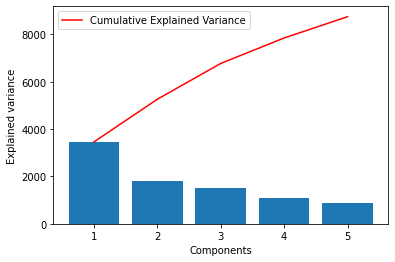

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting explained variance for full expression 
plt.bar(range(1,len(pca5_exp.explained_variance_ )+1),pca5_exp.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca5_exp.explained_variance_ )+1),
         np.cumsum(pca5_exp.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

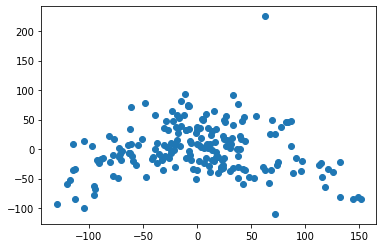

In [10]:
# Plotting full expression
plt.scatter(pca_expression[:, 0], pca_expression[:, 1]) # PC1v2

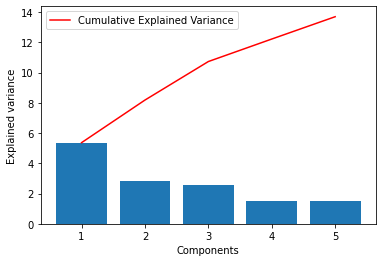

In [11]:
# Plotting explained variance for loci 
plt.bar(range(1,len(pca5_loci.explained_variance_ )+1),pca5_loci.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca5_loci.explained_variance_ )+1),
         np.cumsum(pca5_loci.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

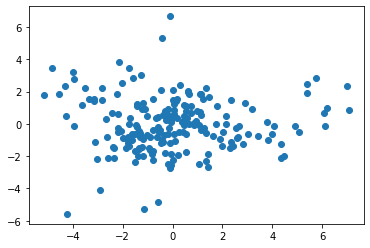

In [12]:
# Plotting loci expression
plt.scatter(pca_loci[:, 0], pca_loci[:, 1]) # PC1v2

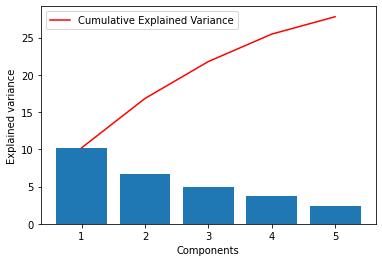

In [13]:
# Plotting explained variance for genes 
plt.bar(range(1,len(pca5_genes.explained_variance_ )+1),pca5_genes.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca5_genes.explained_variance_ )+1),
         np.cumsum(pca5_genes.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

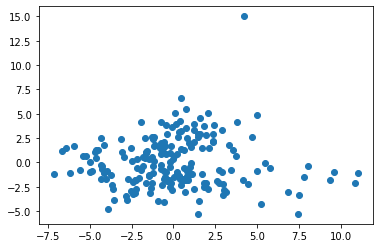

In [14]:
# Plotting genes expression
plt.scatter(pca_genes[:, 0], pca_genes[:, 1]) # PC1v2

In [15]:
PC1_exp = finalDf_expression['PC1'].to_numpy()
PC1_loci = finalDf_loci['PC1'].to_numpy()
PC1_genes = finalDf_genes['PC1'].to_numpy()

PC2_exp = finalDf_expression['PC2'].to_numpy()
PC2_loci = finalDf_loci['PC2'].to_numpy()
PC2_genes = finalDf_genes['PC2'].to_numpy()

PC3_exp = finalDf_expression['PC3'].to_numpy()
PC3_loci = finalDf_loci['PC3'].to_numpy()
PC3_genes = finalDf_genes['PC3'].to_numpy()

PC4_exp = finalDf_expression['PC4'].to_numpy()
PC4_loci = finalDf_loci['PC4'].to_numpy()
PC4_genes = finalDf_genes['PC4'].to_numpy()

PC5_exp = finalDf_expression['PC5'].to_numpy()
PC5_loci = finalDf_loci['PC5'].to_numpy()
PC5_genes = finalDf_genes['PC5'].to_numpy()

In [16]:
# from netneurotools.datasets import fetch_schaefer2018
# from neuromaps.images import annot_to_gifti
# from neuromaps.nulls import alexander_bloch
# schaefer1111 = fetch_schaefer2018('fsaverage')['200Parcels7Networks']
# rotated_PC = alexander_bloch(data=PC1_exp, n_perm=100, parcellation=annot_to_gifti(schaefer1111))

#### PC1

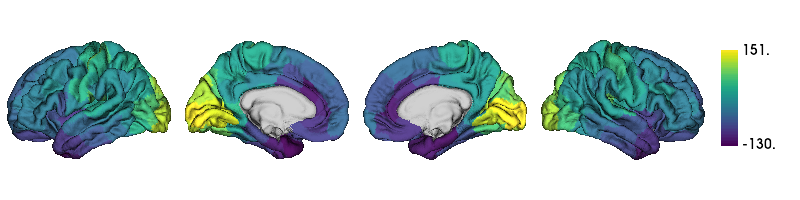

In [17]:
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

# schaefer_fs = fetch_schaefer2018('fsaverage')['200Parcels7Networks']
# schaefer_gii = neuromaps.images.annot_to_gifti(schaefer_fs)
# schaefer_maps = images.load_data(schaefer_gii)
# from nilearn import datasets
# mni152=datasets.load_mni152_template(resolution=2)

schaefer = neuromaps.images.load_data(schaefer_gii)

# PC1_exp = -1*PC1_exp
# PC1_genes = -1*PC1_genes

# Plotting all expression PC1
vertexwise = map_to_labels(
    PC1_exp,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 200),
    zoom=1.2,
    scale=(1,1),
    nan_color=(0.7, 0.7, 0.7, 1), # makes NA's grey 
    layout_style='row', # alternative is grid
    cb__labelTextProperty={"fontSize": 14},
)



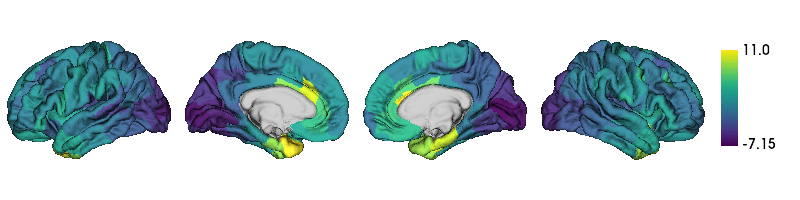

In [18]:
vertexwise = map_to_labels(
    PC1_genes,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 200),
    zoom=1.2,
    scale=(1,1),
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='row',
    cb__labelTextProperty={"fontSize": 14},
)

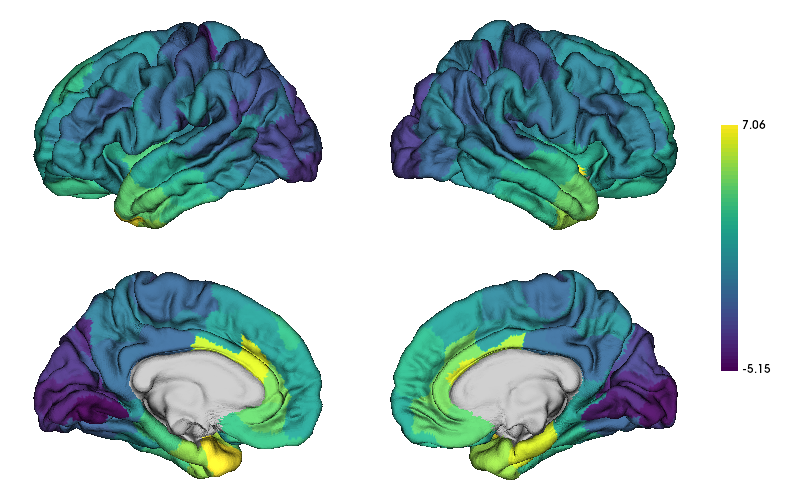

In [19]:
vertexwise = map_to_labels(
    PC1_loci,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

#### PC2

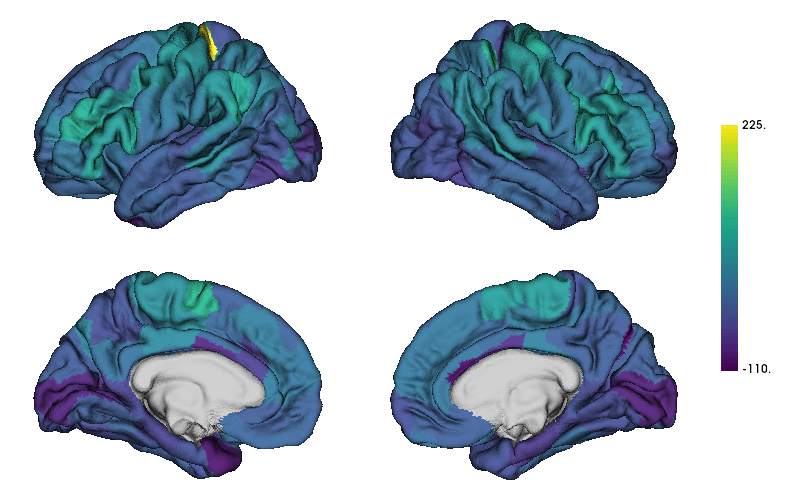

In [20]:
vertexwise = map_to_labels(
    PC2_exp,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

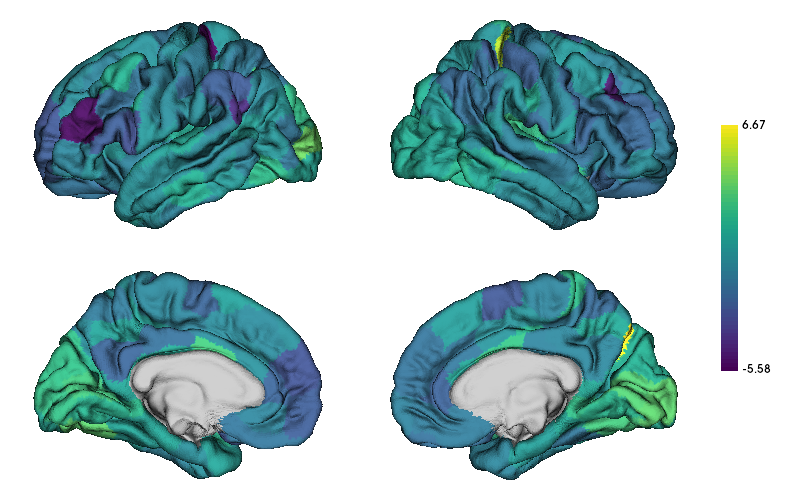

In [21]:
vertexwise = map_to_labels(
    PC2_loci,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

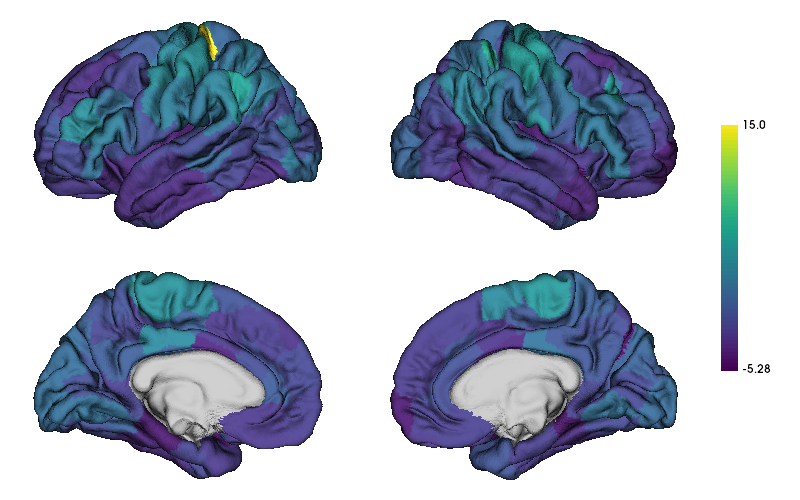

In [22]:
vertexwise = map_to_labels(
    PC2_genes,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

#### PC3

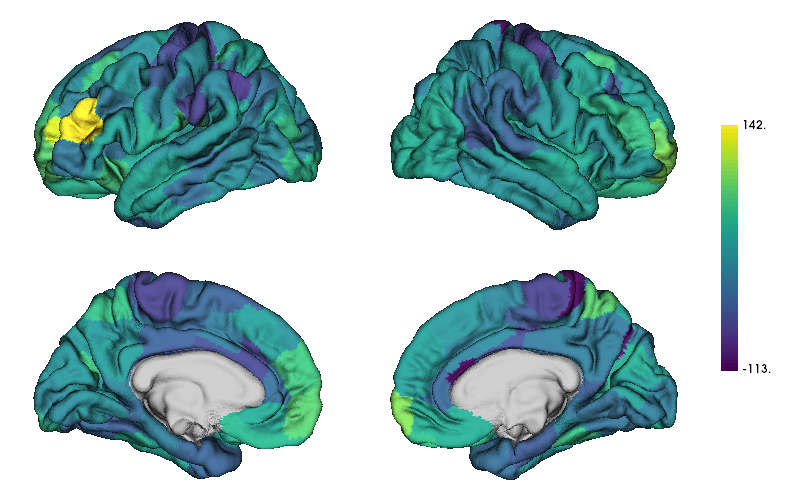

In [23]:
vertexwise = map_to_labels(
    PC3_exp,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

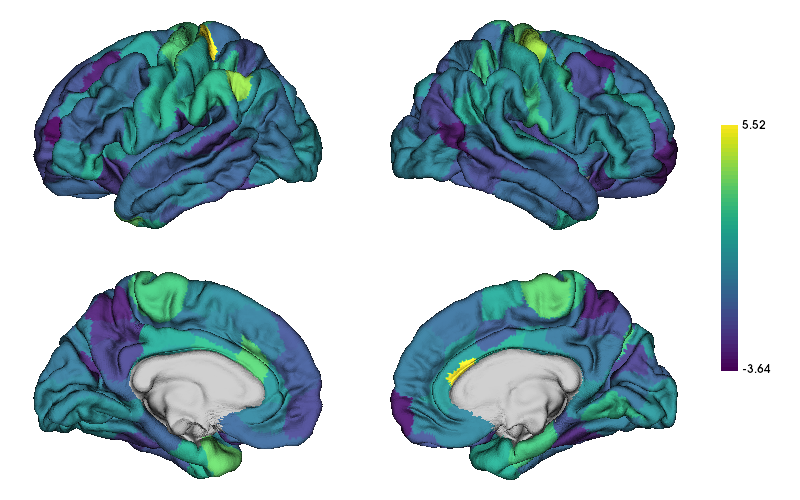

In [24]:
vertexwise = map_to_labels(
    PC3_loci,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

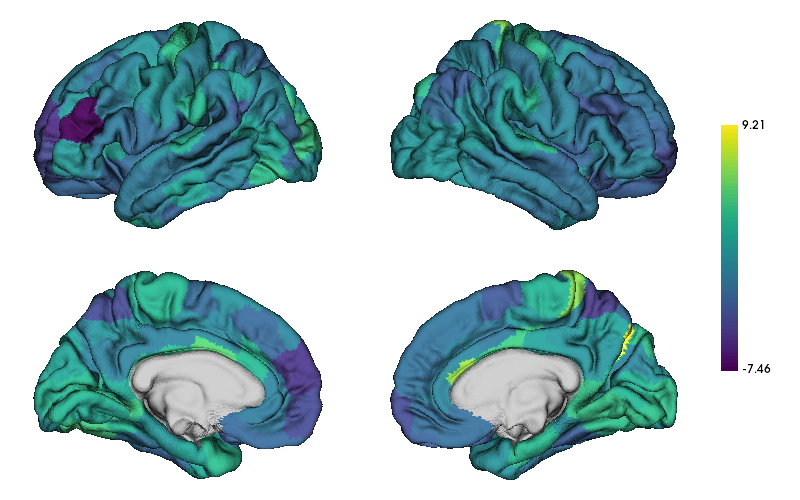

In [25]:
vertexwise = map_to_labels(
    PC3_genes,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

#### PC4

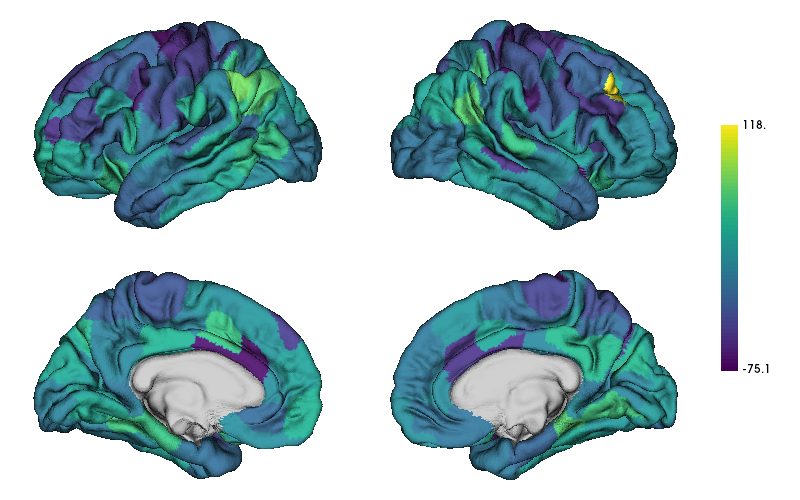

In [26]:
vertexwise = map_to_labels(
    PC4_exp,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

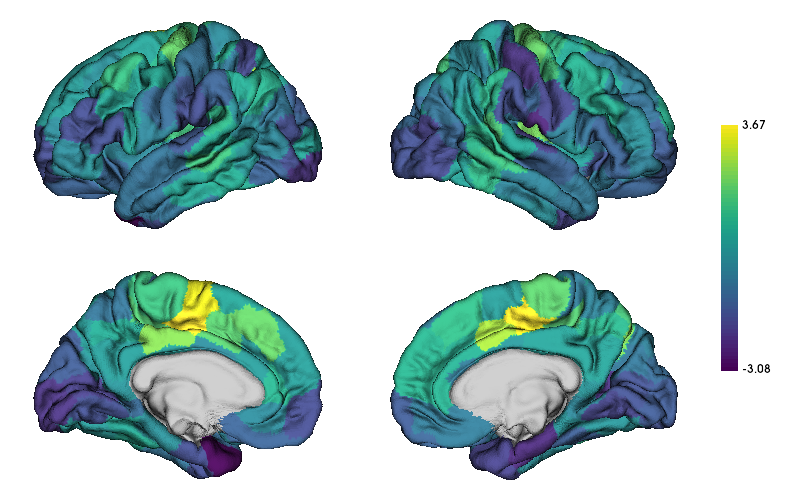

In [27]:
vertexwise = map_to_labels(
    PC4_loci,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

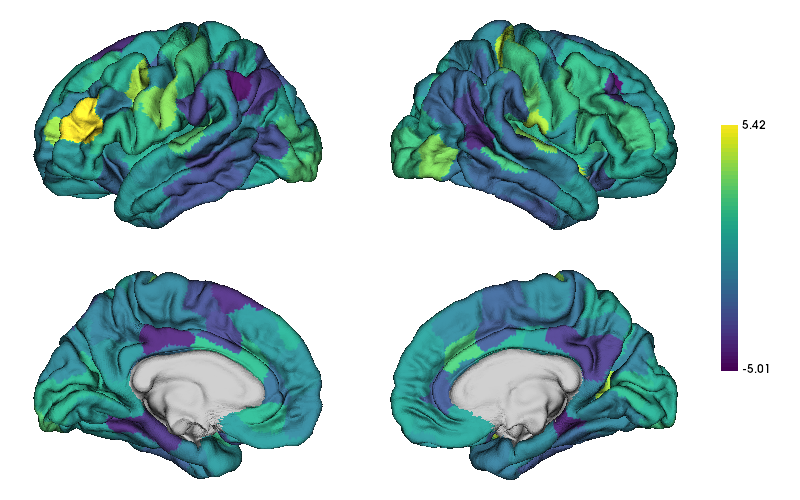

In [28]:
vertexwise = map_to_labels(
    PC4_genes,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

#### PC5

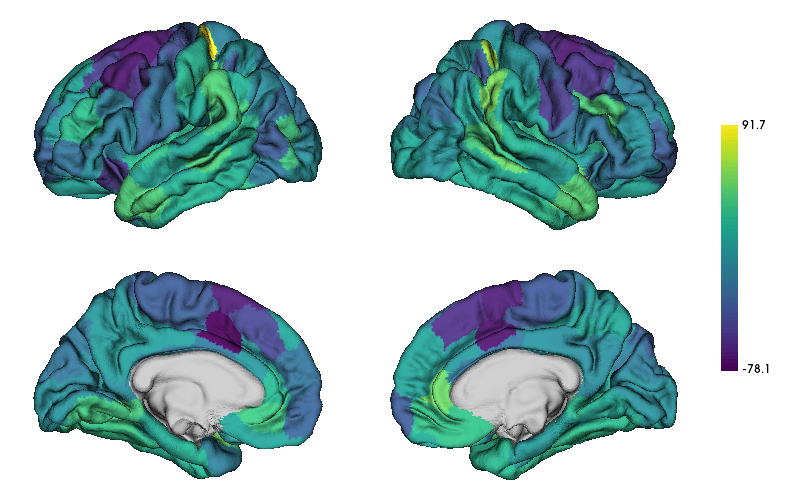

In [29]:
vertexwise = map_to_labels(
    PC5_exp,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

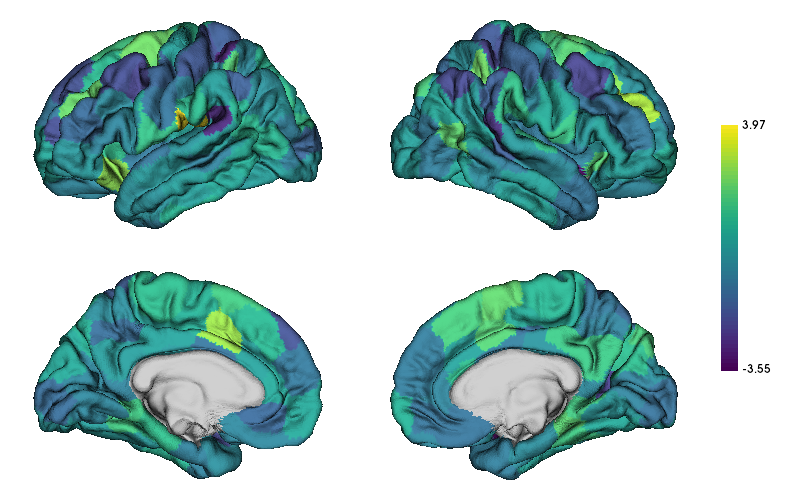

In [30]:
vertexwise = map_to_labels(
    PC5_loci,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

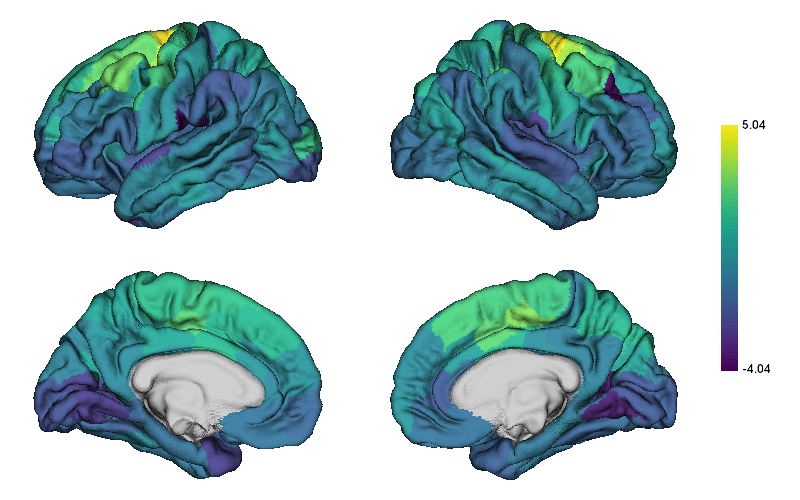

In [31]:
vertexwise = map_to_labels(
    PC5_genes,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

In [5]:
from neuromaps import transforms
from neuromaps.datasets import fetch_annotation
from neuromaps import images
from neuromaps import parcellate
# Grab abagen neuromap of the PC 1 component 
abagen = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
# Grab glasser 360 map 
glasser = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
# Resample images to same space 
from neuromaps.resampling import resample_images
glasser_fsavg, abagen_fsavg = resample_images(src=glasser, trg=abagen,
                                  src_space='fsLR', trg_space='fsaverage',
                                  method='linear', resampling='transform_to_alt',
                                  alt_spec=('fsaverage', '164k'))

schaefer_fs = transforms.fsaverage_to_fsaverage(schaefer_gii, '164k', method='nearest')
schaefer_fs_lh, schaefer_fs_rh = schaefer_fs
print(schaefer_fs_lh.agg_data().shape)
print(schaefer_fs_rh.agg_data().shape)

parcellation = images.relabel_gifti(schaefer_fs)
print(parcellation)
par_lh, par_rh = parcellation
print(par_lh.agg_data().shape)
print(par_rh.agg_data().shape)

schaefer_parc = parcellate.Parcellater(parcellation, 'fsaverage', resampling_target='parcellation')

np.set_printoptions(precision=5)

glasser_parc = schaefer_parc.fit_transform(glasser_fsavg, 'fsaverage', ignore_background_data=True)
print(glasser_parc)

(163842,)
(163842,)
(<nibabel.gifti.gifti.GiftiImage object at 0x7f8a6899d1c0>, <nibabel.gifti.gifti.GiftiImage object at 0x7f8a372f5ee0>)
(163842,)
(163842,)


<IPython.core.display.Javascript object>

[1.37691 1.44371 1.3325  1.50979 1.49453 1.51993 1.52434 1.43027 1.50447
 1.53894 1.38078 1.49729 1.4627  1.45876 1.39228 1.52436 1.4232  1.29911
 1.32725 1.48587 1.52311 1.35035 1.4369  1.56639 1.34051 1.63457 1.43086
 1.36796 1.50949 1.54643 1.28851 1.24316 1.3627  1.30554 1.34853 1.37484
 1.32746 1.38377 1.24911 1.27542 1.35688 1.26725 1.30824 1.3014  1.25645
 1.22058 1.16891 1.23027 1.20059 1.24252 1.20827 1.22165 1.2665  1.29761
 1.26489 1.20464 1.17197 1.19807 1.12572 1.14837 1.24614 1.34239 1.29751
 1.22214 1.23925 1.21631 1.2341  1.24622 1.32869 1.32559 1.38121 1.76561
 1.26125 1.12557 1.23819 1.24452 1.28431 1.3335  1.3273  1.2678  1.2447
 1.26385 1.20004 1.16938 1.26668 1.19378 1.29014 1.1558  1.16706 1.16616
 1.17923 1.21426 1.26024 1.24326 1.20504 1.43158 1.38468 1.31289 1.30534
 1.34987 1.30775 1.33609 1.44759 1.51475 1.41057 1.49672 1.50732 1.48378
 1.57347 1.51731 1.38752 1.48925 1.50457 1.44532 1.38607 1.56376 1.39056
 1.3882  1.50521 1.28609 1.29124 1.47379 1.27682 1.3

In [6]:

np.set_printoptions(precision=2)

glasser_parc = schaefer_parc.fit_transform(glasser_fsavg, 'fsaverage', ignore_background_data=True)
print(glasser_parc)

<IPython.core.display.Javascript object>

[1.38 1.44 1.33 1.51 1.49 1.52 1.52 1.43 1.5  1.54 1.38 1.5  1.46 1.46
 1.39 1.52 1.42 1.3  1.33 1.49 1.52 1.35 1.44 1.57 1.34 1.63 1.43 1.37
 1.51 1.55 1.29 1.24 1.36 1.31 1.35 1.37 1.33 1.38 1.25 1.28 1.36 1.27
 1.31 1.3  1.26 1.22 1.17 1.23 1.2  1.24 1.21 1.22 1.27 1.3  1.26 1.2
 1.17 1.2  1.13 1.15 1.25 1.34 1.3  1.22 1.24 1.22 1.23 1.25 1.33 1.33
 1.38 1.77 1.26 1.13 1.24 1.24 1.28 1.33 1.33 1.27 1.24 1.26 1.2  1.17
 1.27 1.19 1.29 1.16 1.17 1.17 1.18 1.21 1.26 1.24 1.21 1.43 1.38 1.31
 1.31 1.35 1.31 1.34 1.45 1.51 1.41 1.5  1.51 1.48 1.57 1.52 1.39 1.49
 1.5  1.45 1.39 1.56 1.39 1.39 1.51 1.29 1.29 1.47 1.28 1.39 1.55 1.41
 1.57 1.35 1.64 1.44 1.36 1.38 1.57 1.56 1.32 1.4  1.25 1.31 1.34 1.32
 1.37 1.37 1.25 1.28 1.36 1.27 1.28 1.34 1.34 1.28 1.3  1.11 1.25 1.25
 1.19 1.22 1.29 1.27 1.18 1.28 1.2  1.12 1.17 1.27 1.24 1.28 1.35 1.24
 1.22 1.23 1.22 1.23 1.33 1.2  1.22 1.28 1.4  1.66 1.26 1.17 1.21 1.27
 1.29 1.27 1.11 1.18 1.26 1.25 1.38 1.26 1.2  1.14 1.14 1.17 1.19 1.24
 1.24 1

In [36]:
from netneurotools.datasets import fetch_schaefer2018
from neuromaps.images import dlabel_to_gifti
from neuromaps.nulls import alexander_bloch
rotated = alexander_bloch(data=None, atlas='fsaverage', density='164k', n_perm=100, seed=1234, parcellation=schaefer_gii)

In [38]:
# Import ADRC information in Schaefer200 space
tau_data = pd.read_csv('/Users/hobbsd/Documents/GitHub/Neuromaps_Toolbox/regional_tau_data_schaefer7_,200_220822.csv', sep=",")
tau_summary = tau_data[['ROI.Label','region','hemi','baseline_taudif_symptomatic_control']]
tau_diff = tau_summary['baseline_taudif_symptomatic_control'].to_numpy()

In [48]:
from neuromaps.datasets import fetch_annotation
from neuromaps.parcellate import Parcellater

# glasser_parc = parc.fit_transform(glasser, 'fsLR')
# abagen_parc = parc.fit_transform(abagen, 'fsLR')
rotated_glasser = alexander_bloch(data=glasser_parc, atlas='fsaverage', density='164k', n_perm=100, seed=1234, parcellation=schaefer_gii)
rotated_PCexp = alexander_bloch(data=PC1_exp, atlas='fsaverage', density='164k', n_perm=100, seed=1234, parcellation=schaefer_gii)
rotated_PCgene = alexander_bloch(data=PC1_genes, atlas='fsaverage', density='164k', n_perm=100, seed=1234, parcellation=schaefer_gii)
rotated_PCloci = alexander_bloch(data=PC1_loci, atlas='fsaverage', density='164k', n_perm=100, seed=1234, parcellation=schaefer_gii)
rotated_tau_diff = alexander_bloch(data=tau_diff, atlas='fsaverage', density='164k', n_perm=100, seed=1234, parcellation=schaefer_gii)


In [49]:
print(rotated.shape)
#print(rotated_glasser.shape)
print(rotated_PCexp.shape)
print(rotated_PCgene.shape)
print(rotated_PCloci.shape)
print(rotated_tau_diff.shape)

(200, 100)
(200, 100)
(200, 100)
(200, 100)
(200, 100)


In [50]:
from neuromaps import compare_images
corr, pval = compare_images(PC1_exp, glasser_parc, metric='spearmanr', nulls=rotated_PCexp)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.839, p = 0.010


In [51]:
corr, pval = compare_images(glasser_parc, PC1_exp, metric='spearmanr', nulls=rotated_glasser)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.839, p = 0.010


In [43]:
# #Spearman plot 
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# from scipy.stats import spearmanr
# df = pd.DataFrame({"x": glasser_parc, "y": PC1_exp})
# r, pvalue = spearmanr(df['x'], df['y'])
# import seaborn as sns
# sns.regplot(data=df, x="x", y="y", 
#             label=f'Spearman = {r:.2f}',
#             line_kws={"color": "black", "lw":1},
#             scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Myelin Map", 
#                                                            ylabel="PC1: Entire Microarray")
# plt.legend()
# sns.despine()

In [52]:
corr, pval = compare_images(PC1_genes, glasser_parc, metric='spearmanr', nulls=rotated_PCgene)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.523, p = 0.020


In [53]:
corr, pval = compare_images(glasser_parc, PC1_genes, metric='spearmanr', nulls=rotated_glasser)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.523, p = 0.010


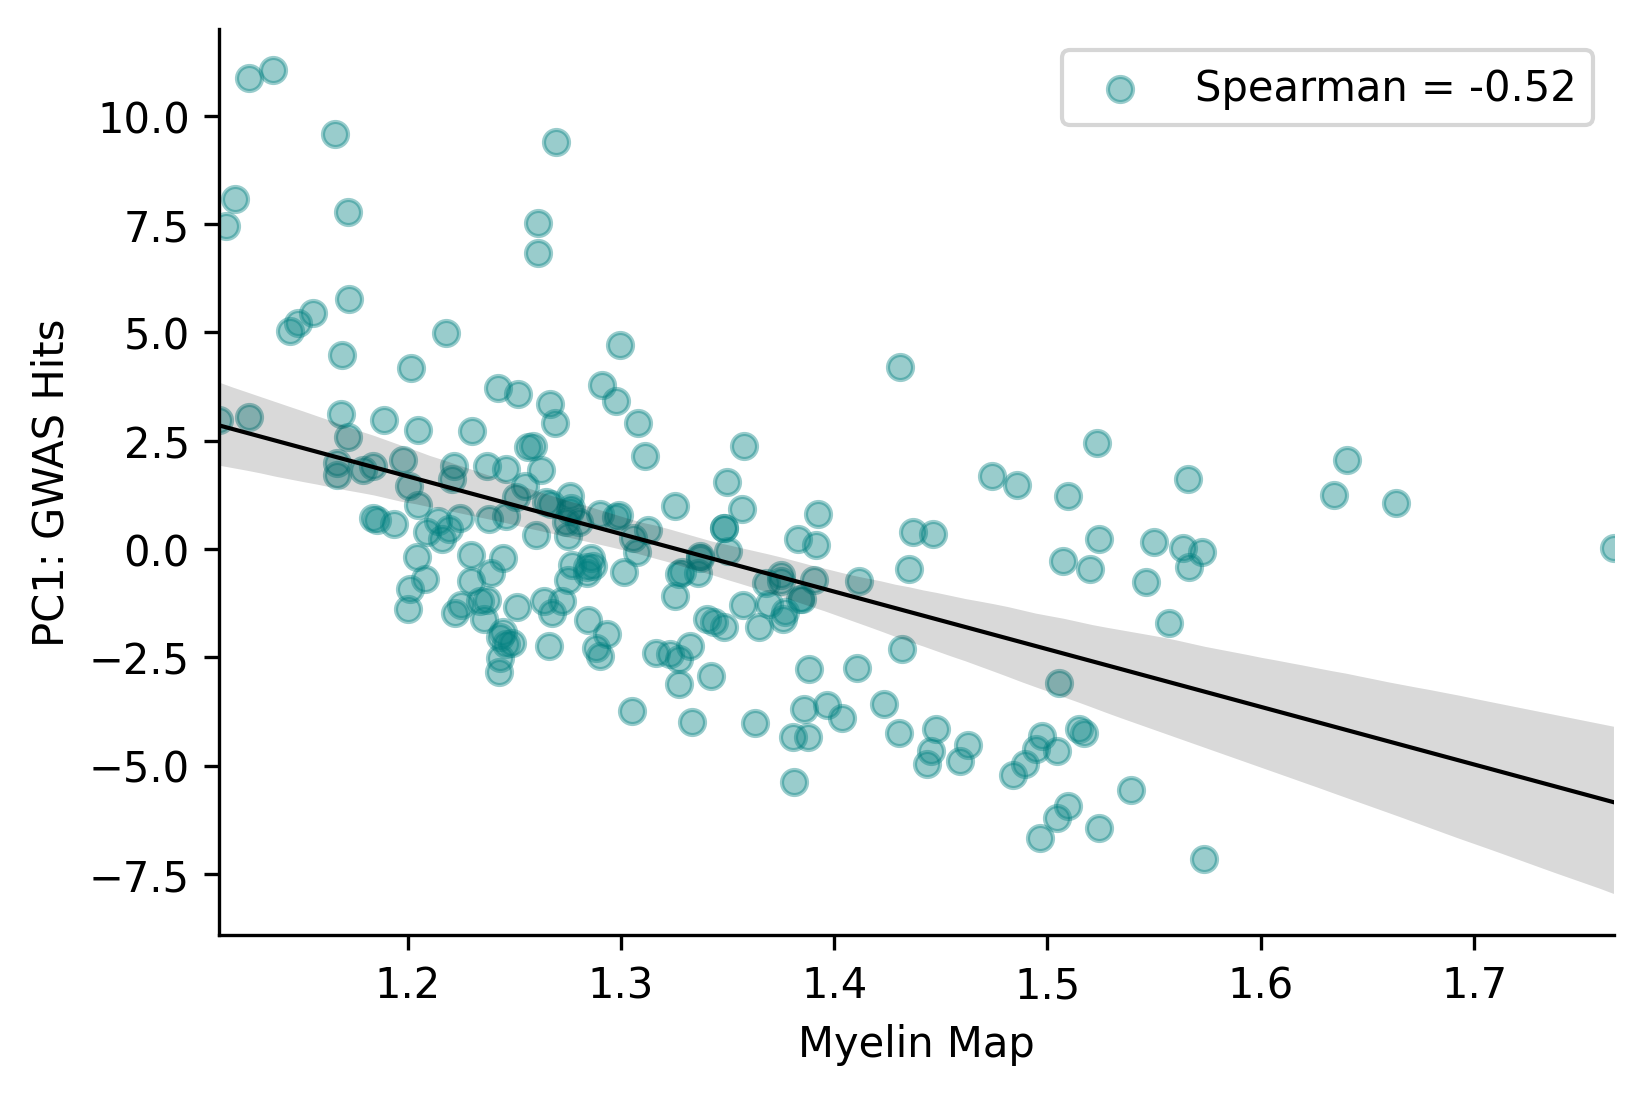

In [61]:
#Spearman plot 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from scipy.stats import spearmanr
df = pd.DataFrame({"x": glasser_parc, "y": PC1_genes})
r, pvalue = spearmanr(df['x'], df['y'])
import seaborn as sns
sns.regplot(data=df, x="x", y="y", 
            label=f'Spearman = {r:.2f}',
            line_kws={"color": "black", "lw":1},
            scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Myelin Map", 
                                                           ylabel="PC1: GWAS Hits")
plt.legend()
sns.despine()

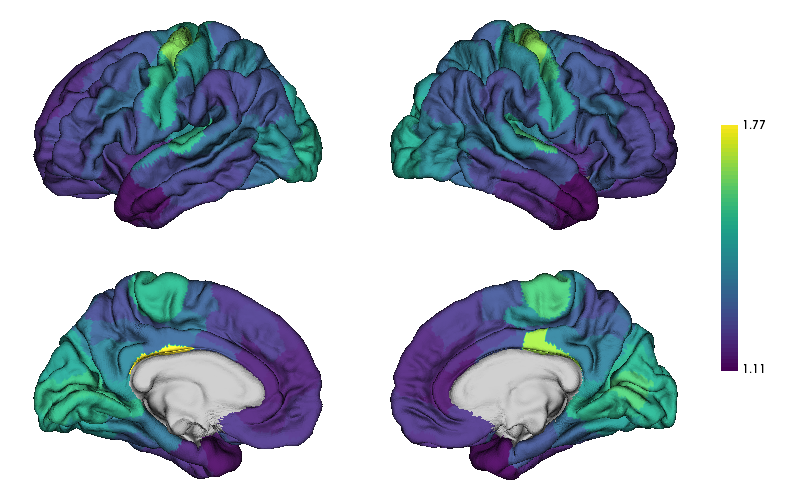

In [62]:
vertexwise = map_to_labels(
    glasser_parc,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

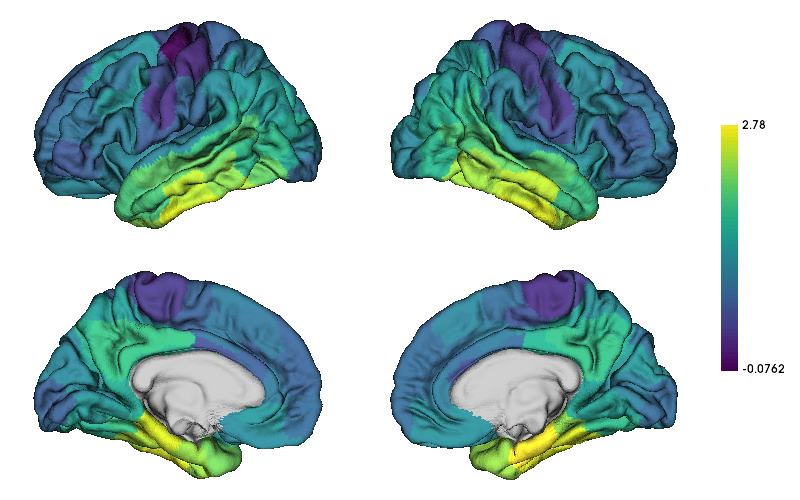

In [55]:
vertexwise = map_to_labels(
    tau_diff,
    schaefer,
    mask=schaefer != 0,
    fill=np.nan,
)
plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise,
    color_bar=True,
    embed_nb=True,
    size=(800, 500),
    zoom=1.5,
    nan_color=(0.7, 0.7, 0.7, 1),
    layout_style='grid',
    cb__labelTextProperty={"fontSize": 12},
)

In [56]:
corr, pval = compare_images(PC1_exp, tau_diff, metric='spearmanr', nulls=rotated_PCexp)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.122, p = 0.812


In [57]:
corr, pval = compare_images(tau_diff, PC1_exp, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.122, p = 0.812


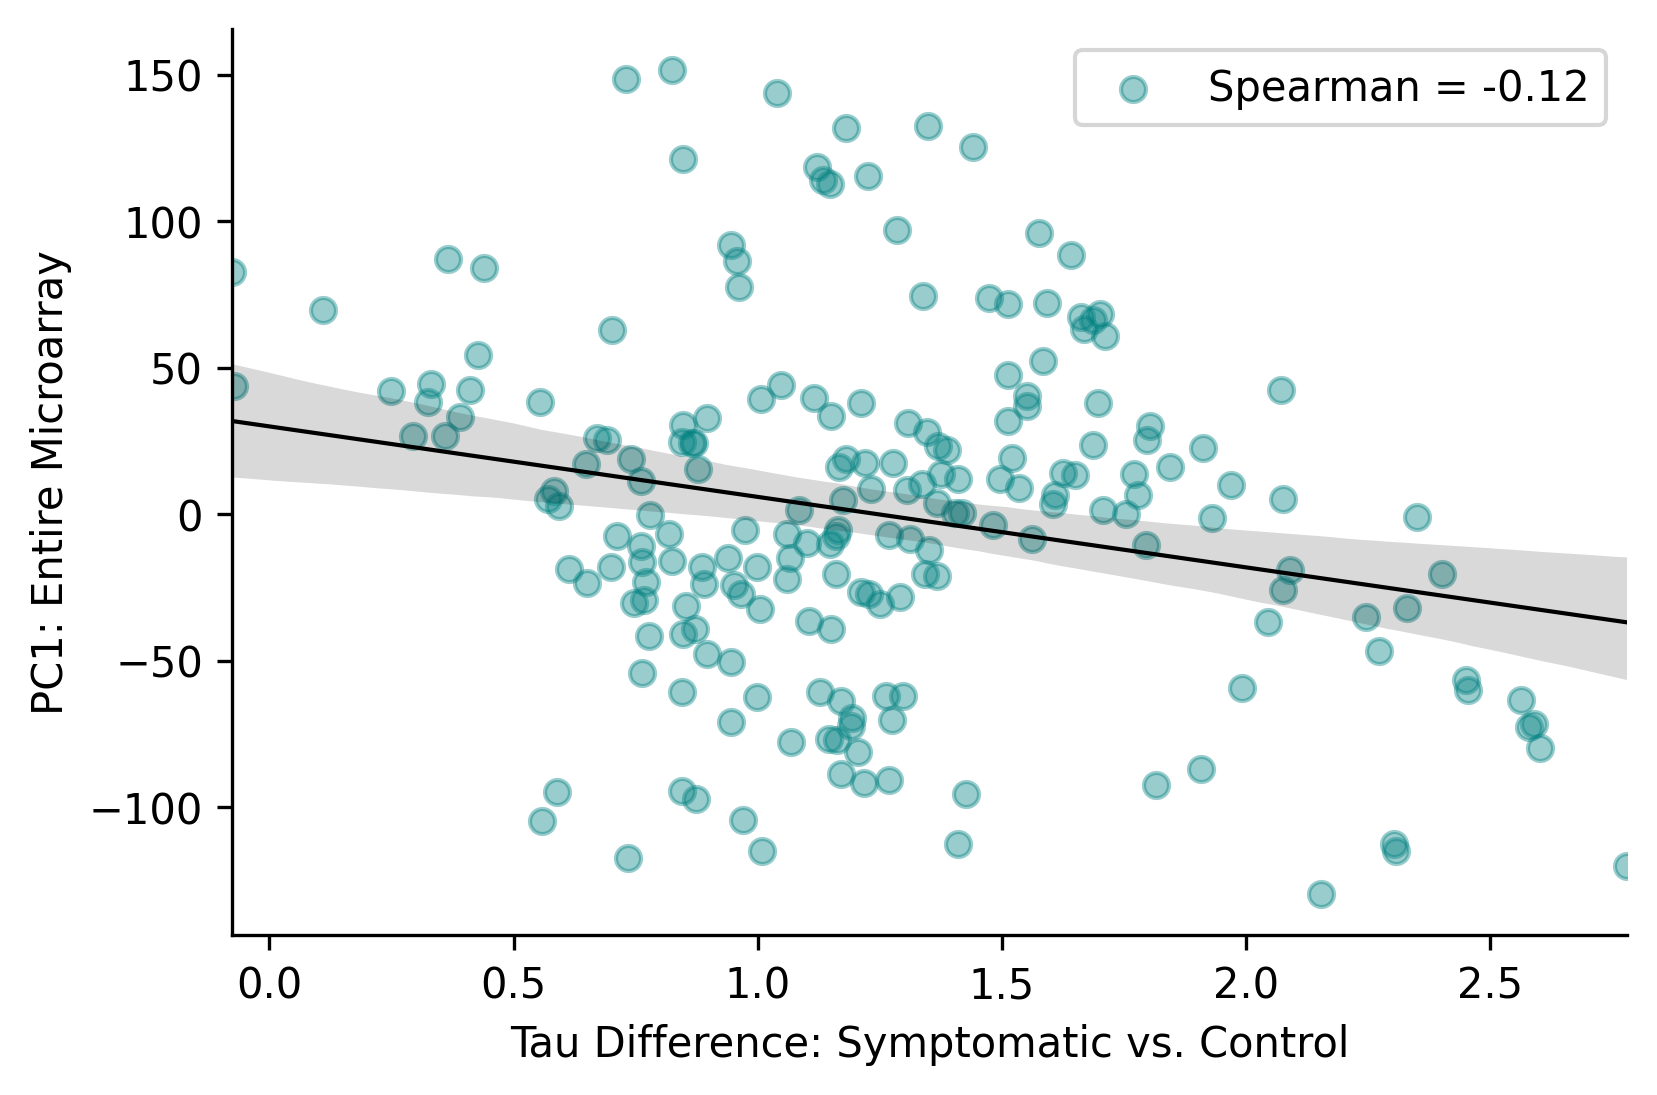

In [58]:
#Spearman plot 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from scipy.stats import spearmanr
df = pd.DataFrame({"x": tau_diff, "y": PC1_exp})
r, pvalue = spearmanr(df['x'], df['y'])
import seaborn as sns
sns.regplot(data=df, x="x", y="y", 
            label=f'Spearman = {r:.2f}',
            line_kws={"color": "black", "lw":1},
            scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Tau Difference: Symptomatic vs. Control", 
                                                           ylabel="PC1: Entire Microarray")
plt.legend()
sns.despine()


In [59]:
corr, pval = compare_images(PC1_genes, tau_diff, metric='spearmanr', nulls=rotated_PCgene)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.217, p = 0.455


In [60]:
corr, pval = compare_images(tau_diff, PC1_genes, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.217, p = 0.554


In [57]:
corr, pval = compare_images(PC1_loci, tau_diff, metric='spearmanr', nulls=rotated_PCloci)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.123, p = 0.802


In [58]:
corr, pval = compare_images(tau_diff, PC1_loci, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.123, p = 0.812


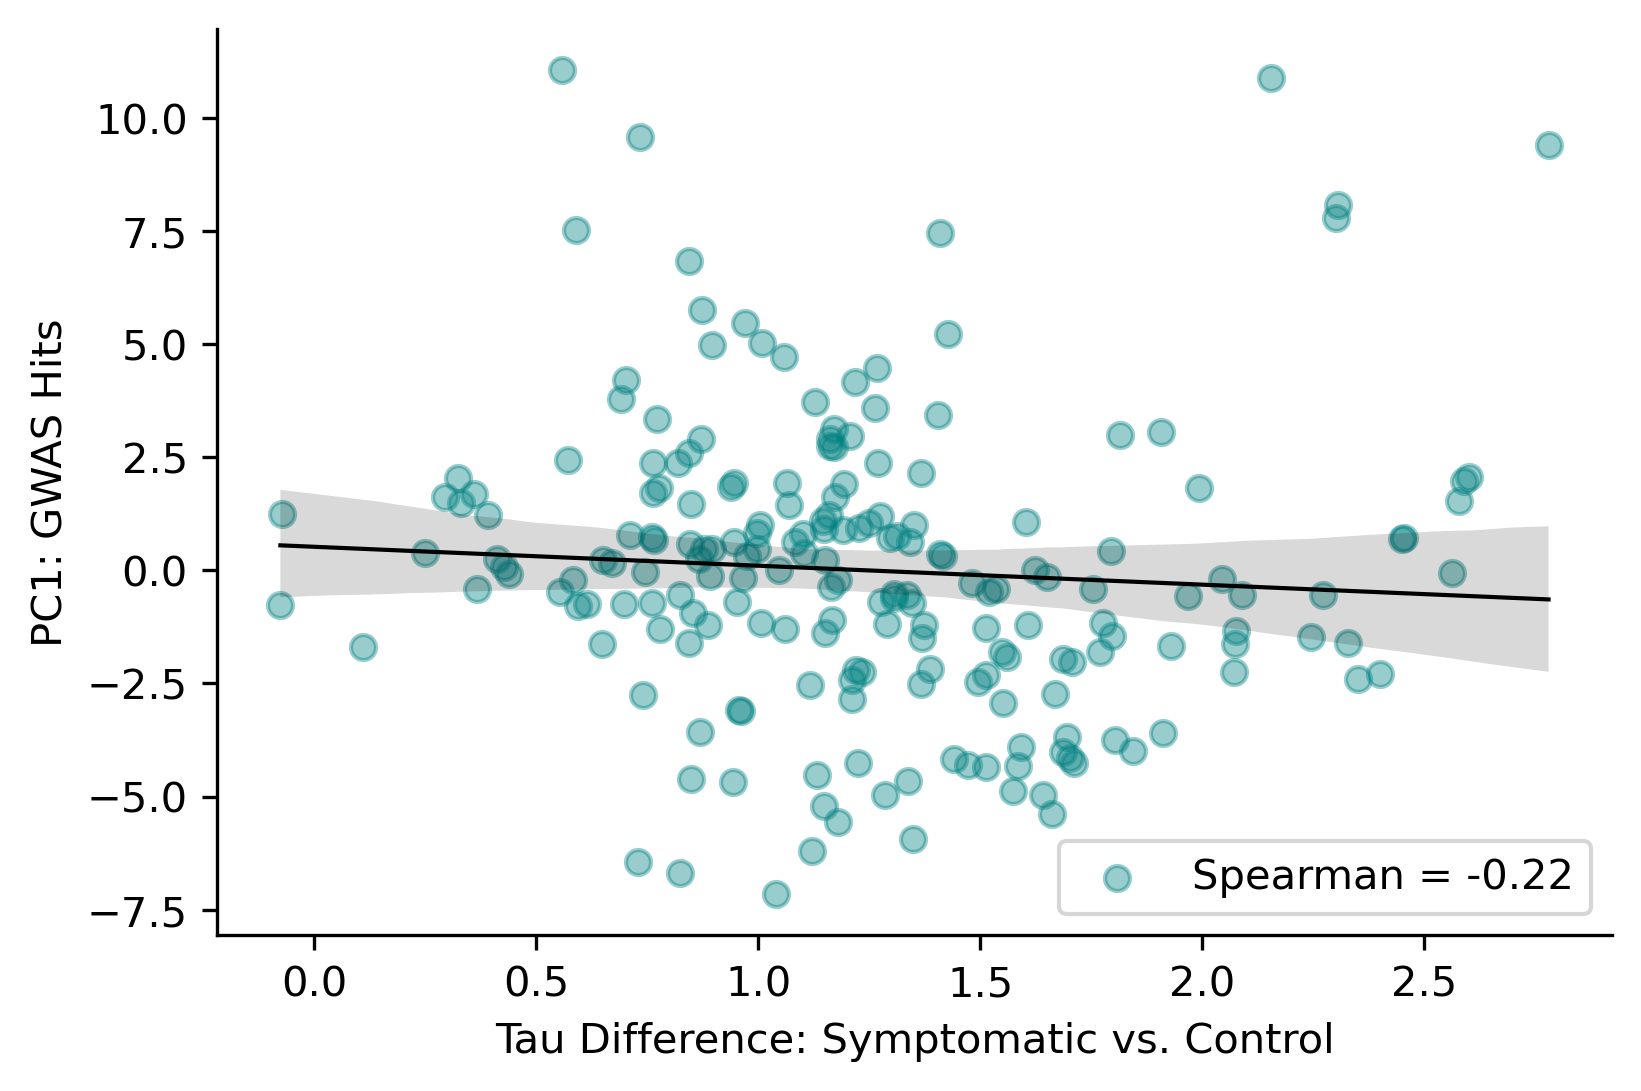

In [59]:
#Spearman plot 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from scipy.stats import spearmanr
df = pd.DataFrame({"x": tau_diff, "y": PC1_genes})
r, pvalue = spearmanr(df['x'], df['y'])
import seaborn as sns
sns.regplot(data=df, x="x", y="y", 
            label=f'Spearman = {r:.2f}',
            line_kws={"color": "black", "lw":1},
            scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Tau Difference: Symptomatic vs. Control", 
                                                           ylabel="PC1: GWAS Hits")
plt.legend()
sns.despine()


In [79]:
APOE = expression["APOE"]
BDNF = expression["BDNF"]
TREM2 = expression["TREM2"]
BACE1 = expression["BACE1"]
BACE2 = expression["BACE2"]
MAPT = expression["MAPT"]

In [61]:
corr, pval = compare_images(tau_diff, APOE, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.187, p = 0.535


In [62]:
corr, pval = compare_images(tau_diff, BDNF, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.421, p = 0.109


In [63]:
corr, pval = compare_images(tau_diff, TREM2, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.345, p = 0.109


In [64]:
corr, pval = compare_images(tau_diff, BACE1, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.362, p = 0.059


In [65]:
corr, pval = compare_images(tau_diff, BACE2, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.255, p = 0.069


In [80]:
corr, pval = compare_images(tau_diff, MAPT, metric='spearmanr', nulls=rotated_tau_diff)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.349, p = 0.010


In [81]:
rotated_APOE = alexander_bloch(data=APOE, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)
rotated_BDNF = alexander_bloch(data=BDNF, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)
rotated_TREM2 = alexander_bloch(data=TREM2, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)
rotated_BACE1 = alexander_bloch(data=BACE1, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)
rotated_BACE2 = alexander_bloch(data=BACE2, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)
rotated_MAPT = alexander_bloch(data=MAPT, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)


In [67]:
corr, pval = compare_images(APOE, tau_diff, metric='spearmanr', nulls=rotated_APOE)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.187, p = 0.475


In [68]:
corr, pval = compare_images(BDNF, tau_diff, metric='spearmanr', nulls=rotated_BDNF)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.421, p = 0.059


In [69]:
corr, pval = compare_images(TREM2, tau_diff, metric='spearmanr', nulls=rotated_TREM2)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.345, p = 0.079


In [70]:
corr, pval = compare_images(BACE1, tau_diff, metric='spearmanr', nulls=rotated_BACE1)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.362, p = 0.050


In [71]:
corr, pval = compare_images(BACE2, tau_diff, metric='spearmanr', nulls=rotated_BACE2)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.255, p = 0.030


In [82]:
corr, pval = compare_images(MAPT, tau_diff, metric='spearmanr', nulls=rotated_MAPT)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = 0.349, p = 0.010


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

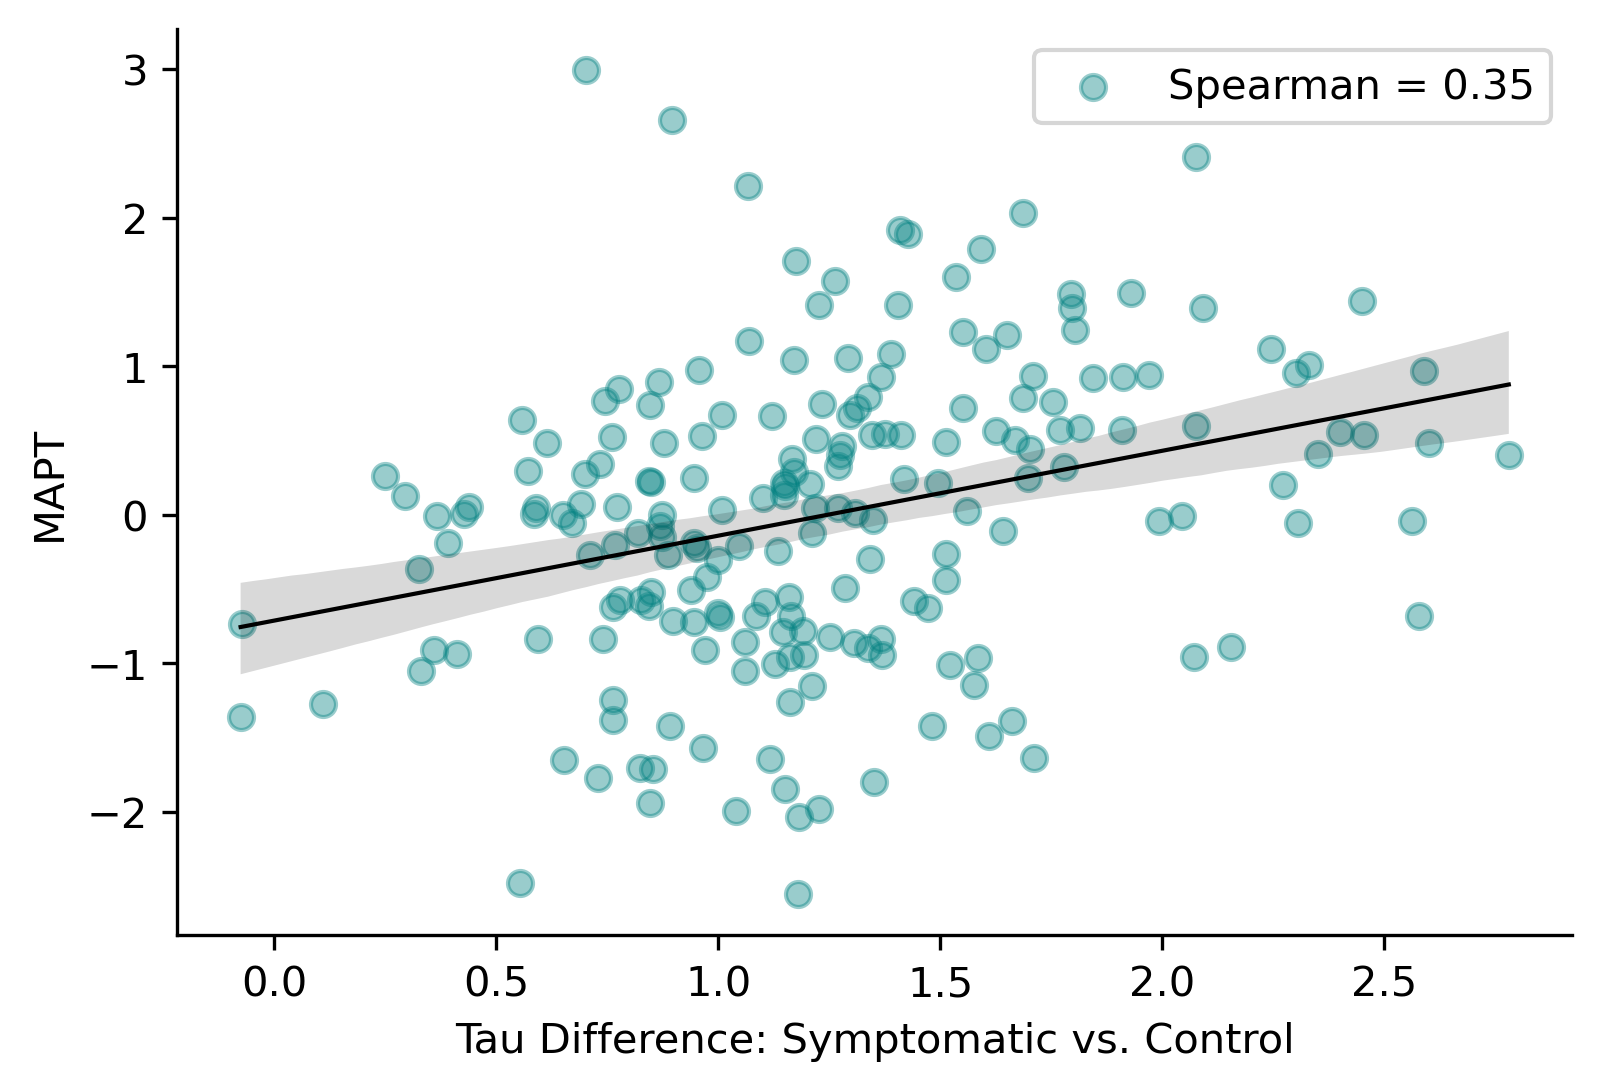

In [83]:
#Spearman plot 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from scipy.stats import spearmanr
df = pd.DataFrame({"x": tau_diff, "y": MAPT})
r, pvalue = spearmanr(df['x'], df['y'])
import seaborn as sns
sns.regplot(data=df, x="x", y="y", 
            label=f'Spearman = {r:.2f}',
            line_kws={"color": "black", "lw":1},
            scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Tau Difference: Symptomatic vs. Control", 
                                                           ylabel="MAPT")
plt.legend()
sns.despine()

In [72]:
test = expression [["ABCA7", "BIN1", 'CD2AP', 'CD33', 'CELF1', "CLU", 'EPHA1', 
                    "FERMT2", "INPP5D", 'MEF2C', "PICALM", 'PTK2B',  'RIN3', 'ZCWPW1']]

In [73]:
pca5_test = PCA(n_components=5)
pca_test = pca5_test.fit_transform(test)
pca_Df_test = pd.DataFrame(data=pca_test, columns = ['PC1','PC2','PC3','PC4','PC5'])
finalDf_test = pd.concat([labels,pca_Df_test], axis=1)
PC1_test = finalDf_test['PC1'].to_numpy()


In [74]:
rotated_test = alexander_bloch(data=PC1_test, atlas='fsaverage', density='164k', n_perm=100, parcellation=schaefer_gii)


In [75]:
corr, pval = compare_images(PC1_test, tau_diff, metric='spearmanr', nulls=rotated_test)
print(f'r = {corr:.3f}, p = {pval:.3f}')

r = -0.077, p = 0.792


In [76]:
# fig, axs = plt.subplots(2, 3)
# sns.regplot(data=df, x=tau_diff, y=PC1_genes, 
#             label=f'Spearman = {r:.2f}',
#             line_kws={"color": "black", "lw":1},
#             scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Tau Difference: Symptomatic vs. Control", 
#                                                            ylabel="PC1: GWAS Hits")
# sns.regplot(data=df, x=tau_diff, y=PC1_genes, 
#             label=f'Spearman = {r:.2f}',
#             line_kws={"color": "black", "lw":1},
#             scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Tau Difference: Symptomatic vs. Control", 
#                                                            ylabel="PC1: GWAS Hits")

# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(sns.regplot(data=df, x=tau_diff, y=PC1_genes, 
#             label=f'Spearman = {r:.2f}',
#             line_kws={"color": "black", "lw":1},
#             scatter_kws={"color": "teal","alpha":0.4}).set(xlabel="Tau Difference: Symptomatic vs. Control", 
#                                                            ylabel="PC1: GWAS Hits"))

# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [77]:
# fig, axs = plt.subplots(2, 3)
# sns.regplot(x="x", y="y", data=df, 
#             label=f'Spearman = {r:.2f}',
#             line_kws={"color": "black", "lw":1},
#             scatter_kws={"color": "teal","alpha":0.4},
#             ax=axs[0.0])


In [ ]:
# atlas_info = pd.read_csv('/Users/hobbsd/Documents/GitHub/Neuromaps_Toolbox/schaefer_atlas_info.csv', sep=",")
# from abagen import images
# atlas = ('/Users/hobbsd/abagen-data/Parcellations/FreeSurfer5.3/fsaverage/label/lh.Schaefer2018_200Parcels_7Networks_order.annot',
#          '/Users/hobbsd/abagen-data/Parcellations/FreeSurfer5.3/fsaverage/label/rh.Schaefer2018_200Parcels_7Networks_order.annot')
# surf = ('/Users/hobbsd/abagen-data/Parcellations/FreeSurfer5.3/fsaverage/surf/lh.pial',
#        '/Users/hobbsd/abagen-data/Parcellations/FreeSurfer5.3/fsaverage/surf/rh.pial')
# atlas = neuromaps.images.annot_to_gifti(atlas)
# test = images.check_atlas(atlas, atlas_info)